In [1]:
#shifting from cpu to gpu
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [2]:
#installing some extra required libraries
%pip install statsmodels
%pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00


In [3]:
#importing all required libraries
import csv
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

In [137]:
#import dataset
CSV_URL = 'https://data.montgomerycountymd.gov/resource/39y2-cdbh.csv'

# Set parameters since you can only import 1000 rows at a go
offset = 0  # Starting offset
limit = 1000  # Number of records per request

# Initialize an empty list to store CSV data
csv_data = []

# Loop through the API data using offset and limit
while True:
    # Construct API URL with offset and limit parameters
    api_url = f"{CSV_URL}?$offset={offset}&$limit={limit}"

    # Fetch data from API
    with requests.Session() as s:
        download = s.get(api_url)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        temp=list(cr)
        csv_data.extend(temp)

    # Check if the number of fetched records is less than the limit
    if len(temp) < limit:
        break

    # Increment offset for the next request
    offset += limit

# Convert CSV data to a DataFrame
raw_data = pd.DataFrame(csv_data)


(180408, 38)


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Police District Number,Location,Council Districts,Councils,Communities,Zip Codes,Municipalities,Council Districts_from_i23j_3mj8,Service Regions,Montgomery County Boundary
1,201472433,1207,240015400,04/02/2024 05:36:31 PM,120,1,Crime Against Property,Robbery,ROBBERY - RESIDENTIAL-GUN,MONTGOMERY VILLAGE,...,6D,"(39.158, -77.2075)",2,2,38,28,1,2,5,1
2,201472418,9105,240015405,04/02/2024 05:18:30 PM,90Z,1,Crime Against Society,All Other Offenses,LOST PROPERTY,WHEATON,...,4D,"(39.0903, -77.0537)",4,4,59,6,1,4,4,1
3,201472414,2902,240015392,04/02/2024 04:38:29 PM,290,1,Crime Against Property,Destruction/Damage/Vandalism of Property,DAMAGE PROPERTY - PRIVATE,BETHESDA,...,2D,"(0.0, 0.0)",,,,,,,,
4,201472430,2399,240015387,04/02/2024 04:11:34 PM,23H,1,Crime Against Property,All other Larceny,LARCENY (DESCRIBE OFFENSE),MONTGOMERY VILLAGE,...,6D,"(39.15, -77.1759)",3,3,36,35,21,3,5,1


In [ ]:
df=raw_data
# Print the shape of the DataFrame
print(df.shape)
df.head(5)

In [138]:
#make the first row as column names and reset the index
columns = df.iloc[0,:]
df.set_axis(columns, axis=1, inplace=True)
df.drop(df.index[0],inplace=True)

#reset the index
df.reset_index(drop=True,inplace=True)

#drop rows that have column names and reset index
#since the api was restricted to 1000 rows, we had to extract data 177k/100 times, everytime we did that, the column names were also imported 177 times, we need to remove these 177 rows
a=0
c=0
for i in df['PRA']: #can use any column name
  if i =='PRA':
    df.drop(c,inplace=True)
    a=a+1
  c=c+1
print(a)#no of rows dropeed
df.reset_index(drop=True,inplace=True)

print(df.shape)
df.head(5)

180
(180227, 38)


,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Police District Number,Location,Council Districts,Councils,Communities,Zip Codes,Municipalities,Council Districts_from_i23j_3mj8,Service Regions,Montgomery County Boundary
0,201472433,1207,240015400,04/02/2024 05:36:31 PM,120,1,Crime Against Property,Robbery,ROBBERY - RESIDENTIAL-GUN,MONTGOMERY VILLAGE,...,6D,"(39.158, -77.2075)",2,2,38,28,1,2,5,1
1,201472418,9105,240015405,04/02/2024 05:18:30 PM,90Z,1,Crime Against Society,All Other Offenses,LOST PROPERTY,WHEATON,...,4D,"(39.0903, -77.0537)",4,4,59,6,1,4,4,1
2,201472414,2902,240015392,04/02/2024 04:38:29 PM,290,1,Crime Against Property,Destruction/Damage/Vandalism of Property,DAMAGE PROPERTY - PRIVATE,BETHESDA,...,2D,"(0.0, 0.0)",,,,,,,,
3,201472430,2399,240015387,04/02/2024 04:11:34 PM,23H,1,Crime Against Property,All other Larceny,LARCENY (DESCRIBE OFFENSE),MONTGOMERY VILLAGE,...,6D,"(39.15, -77.1759)",3,3,36,35,21,3,5,1
4,201472406,5016,240015390,04/02/2024 04:11:29 PM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,5D,"(39.184, -77.2618)",2,2,39,39,1,2,5,1


In [139]:
i=0
for j in df.columns:
  print(f'{j} HAS {len(df.iloc[:,i].unique())} UNIQUE VALUES')
  i=i+1

Incident ID HAS 163440 UNIQUE VALUES
Offence Code HAS 282 UNIQUE VALUES
CR Number HAS 163426 UNIQUE VALUES
Dispatch Date / Time HAS 162903 UNIQUE VALUES
NIBRS Code HAS 55 UNIQUE VALUES
Victims HAS 9 UNIQUE VALUES
Crime Name1 HAS 5 UNIQUE VALUES
Crime Name2 HAS 55 UNIQUE VALUES
Crime Name3 HAS 293 UNIQUE VALUES
Police District Name HAS 9 UNIQUE VALUES
Block Address HAS 18142 UNIQUE VALUES
City HAS 78 UNIQUE VALUES
State HAS 9 UNIQUE VALUES
Zip Code HAS 66 UNIQUE VALUES
Agency HAS 7 UNIQUE VALUES
Place HAS 99 UNIQUE VALUES
Sector HAS 16 UNIQUE VALUES
Beat HAS 45 UNIQUE VALUES
PRA HAS 790 UNIQUE VALUES
Address Number HAS 368 UNIQUE VALUES
Street Prefix HAS 5 UNIQUE VALUES
Street Name HAS 7172 UNIQUE VALUES
Street Suffix HAS 6 UNIQUE VALUES
Street Type HAS 30 UNIQUE VALUES
Start_Date_Time HAS 132219 UNIQUE VALUES
End_Date_Time HAS 62802 UNIQUE VALUES
Latitude HAS 14694 UNIQUE VALUES
Longitude HAS 4042 UNIQUE VALUES
Police District Number HAS 8 UNIQUE VALUES
Location HAS 21026 UNIQUE VALUES

In [140]:
df['Crime Name1'].unique()

array(['Crime Against Property', 'Crime Against Society',
       'Crime Against Person', 'Crime Against Not a Crime',
       'Crime Against Person, Property, or Society'], dtype=object)

In [8]:
for j in df['Crime Name1'].unique():
  print(j)
  count=0
  for i in df['Crime Name2'][df['Crime Name1']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

Crime Against Property
Counterfeiting/Forgery
Shoplifting
Destruction/Damage/Vandalism of Property
Theft from Building
Theft of Motor Vehicle Parts or Accessories
Motor Vehicle Theft
Burglary/Breaking and Entering
All other Larceny
Robbery
Extortion/Blackmail
Wire Fraud
Credit Card/Automatic Teller Machine Fraud
Identity Theft
Theft From Motor Vehicle
Embezzlement
False Pretenses/Swindle/Confidence Game
Arson
Impersonation
Pocket/picking
Hacking/Computer Invasion
Stolen Property Offenses
Purse-snatching
From Coin/Operated Machine or Device
Welfare Fraud
Bribery
25


Crime Against Society
All Other Offenses
Drug Equipment Violations
Driving Under the Influence
Trespass of Real Property
Liquor Law Violations
Disorderly Conduct
Weapon Law Violations
Drug/Narcotic Violations
Family Offenses, NonViolent
Animal Cruelty
Pornography/Obscene Material
Prostitution
Assisting or Promoting Prostitution
Curfew/Loitering/Vagrancy Violations
14


Crime Against Person
Simple Assault
Aggravated Assault


# **CRIME NAME RECATEGORIZATION FUNCTION**

In [141]:
#fucntion to reorganise the categories
#old,new = crime name 3, onl2,new2 = crime name 2, choose = 1 crime name 3, choose 2 = crime name 2, True = Worn on Crime name 3, false = no work on crime name 3
def recat(old,new,old2,new2,chose,a=True):
  if a:
    if chose==1:
      for i in range(len(old)):
        df['Crime Name3'][df['Crime Name3']==old[i]] = new[i]
    if chose==2:
      for i in range(len(old)):
        df['Crime Name3'][df['Crime Name2']==old[i]] = new[i]
  for i in range(len(old2)):
    df['Crime Name2'][df['Crime Name2']== old2[i]] = new2

## **CRIME AGAINST PERSON REORGANIZATION**

In [142]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Person'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

Simple Assault
ASSAULT - 2ND DEGREE
ASSAULT - SIMPLE
2


Forcible Fondling
SEX ASSAULT - FONDLING
SEX ASSAULT - CARNAL ABUSE
SEX OFFENSE - FONDLING
SEX OFFENSE - AGAINST CHILD-FONDLING
SEX ABUSE - FONDLING
5


Aggravated Assault
ASSAULT - AGGRAVATED - NON-FAMILY-STRONG-ARM
ASSAULT - AGGRAVATED - NON-FAMILY-GUN
ASSAULT - AGGRAVATED - OTHER
ASSAULT - AGGRAVATED - GUN
ASSAULT - AGGRAVATED - NON-FAMILY-OTHER WEAPON
ASSAULT - AGGRAVATED - POL OFF-OTHER WEAPON
ASSAULT - AGGRAVATED - FAMILY-OTHER WEAPON
ASSAULT - AGGRAVATED - FAMILY-STRONG-ARM
ASSAULT - AGGRAVATED - FAMILY-GUN
ASSAULT - AGGRAVATED - PUB OFF-OTHER WEAPON
ATTEMPTED ASSAULT AGGRAVATED POL OFF KNIFE
ASSAULT - AGGRAVATED - POL OFF-STRONG-ARM
ASSAULT - AGGRAVATED - PUB OFF-GUN
ASSAULT - AGGRAVATED - POL OFF-GUN
ASSAULT - AGGRAVATED - PUB OFF-STRONG-ARM
ASSAULT - AGGRAVATED - POL OFF-KNIFE
16


Sexual Assault With An Object
SEX ASSAULT - WITH AN OBJECT
1


Forcible Rape
RAPE - STRONG-ARM
RAPE - GUN
RAPE WITH WEAPON
3


Forcible Sodo

In [143]:
old= ['Statuory Rape','Forcible Rape','Forcible Fondling','Sexual Assault With An Object','Forcible Sodomy','Incest']
new= ['RAPE','RAPE','FONDLING','WITH WEAPON','FORCIBLE SODOMY','INCEST WITH MINOR']
old2=['Statuory Rape','Forcible Rape','Forcible Fondling','Sexual Assault With An Object','Forcible Sodomy','Incest']
new2='Sex Offence'

recat(old,new,old2,new2,2)

In [144]:
old= ['HUMAN TRAFFICKING - COMMERCIAL SEX ACTS','HUMAN TRAFFICKING - INVOLUNTARY SERITUDE']
new= ['COMMERCIAL SEX ACTS','INVOLUNTARY SERITUDE']
old2=['Human Trafficking, Commercial Sex Acts', 'Human Trafficking, Involuntary Servitude']
new2='Human Trafficking'

recat(old,new,old2,new2,1)

In [145]:
old= ['ASSAULT - SIMPLE', 'ASSAULT - 2ND DEGREE', 'ASSAULT - AGGRAVATED - FAMILY-OTHER WEAPON', 'ASSAULT - AGGRAVATED - NON-FAMILY-OTHER WEAPON', 'ASSAULT - AGGRAVATED - PUB OFF-OTHER WEAPON', 'ASSAULT - AGGRAVATED - POL OFF-OTHER WEAPON', 'ASSAULT - AGGRAVATED - POL OFF-KNIFE', 'ASSAULT - AGGRAVATED - NON-FAMILY-GUN', 'ASSAULT - AGGRAVATED - GUN', 'ASSAULT - AGGRAVATED - FAMILY-GUN', 'ASSAULT - AGGRAVATED - POL OFF-GUN', 'ASSAULT - AGGRAVATED - PUB OFF-GUN', 'ASSAULT - AGGRAVATED - POL OFF-STRONG-ARM', 'ASSAULT - AGGRAVATED - FAMILY-STRONG-ARM', 'ASSAULT - AGGRAVATED - NON-FAMILY-STRONG-ARM', 'ASSAULT - AGGRAVATED - PUB OFF-STRONG-ARM', 'ASSAULT - AGGRAVATED - OTHER']
new= ['SIMPLE', '2ND DEGREE', 'WEAPON', 'WEAPON', 'WEAPON', 'WEAPON', 'WEAPON', 'GUN', 'GUN', 'GUN', 'GUN', 'GUN', 'STRONG ARM', 'STRONG ARM', 'STRONG ARM', 'STRONG ARM', 'OTHER']
old2=['Simple Assault', 'Aggravated Assault']
new2='Assault'

recat(old,new,old2,new2,1)

In [146]:
old= ['ASSAULT - INTIMIDATION (INCLUDES STALKING)','WEAPON - THREAT TO BOMB','WEAPON - THREAT TO BURN']
new= ['INTIMIDATION BY STALKING)','THREAT TO BOMB','THREAT TO BURN']
old2=['Intimidation']
new2='Intimidation'

recat(old,new,old2,new2,1)

In [147]:
old= df['Crime Name3'][df['Crime Name2']=='Kidnapping/Abduction'].unique()
new= ['ADULT','MINOR','UNDESCRIBED','MINOR','MINOR','ABUDCT','ADULT FOR RANSOM','MINOR FOR RANSOM']
old2=['Kidnapping/Abduction']
new2='Kidnapping'

recat(old,new,old2,new2,1)

In [148]:
old= ['HUMAN TRAFFICKING - COMMERCIAL SEX ACTS','HUMAN TRAFFICKING - INVOLUNTARY SERITUDE']
new= ['COMMERCIAL SEX ACTS','INVOLUNTARY SERITUDE']
old2=['Human Trafficking, Commercial Sex Acts','Human Trafficking, Involuntary Servitude']
new2='Human Trafficking'

recat(old,new,old2,new2,1)

In [149]:
old= ['HOMICIDE - JUSTIFIABLE', 'HOMICIDE - BY POLICE - JUSTIFIABLE', 'HOMICIDE - BY NON-POLICE - JUSTIFIABLE', 'HOMICIDE - NEGLIGENT MANSLAUGHTER', 'HOMICIDE - WILLFUL KILL-GUN', 'HOMICIDE - WILLFUL KILL-FAMILY-GUN', 'HOMICIDE - WILLFUL KILL-NON-FAMILY-GUN', 'HOMICIDE (DESCRIBE OFFENSE)', 'HOMICIDE - WILLFUL KILL', 'HOMICIDE - WILLFUL KILL-NON-FAMILY', 'HOMICIDE - JOHN OR JANE DOE - NO WARRANT', 'ASSAULT - AGGRAVATED - POL OFF-STRONG-ARM', 'ASSAULT - AGGRAVATED - FAMILY-STRONG-ARM', 'ASSAULT - AGGRAVATED - NON-FAMILY-STRONG-ARM', 'ASSAULT - AGGRAVATED - PUB OFF-STRONG-ARM', 'ASSAULT - AGGRAVATED - OTHER']
new= ['JUSTIFIABLE', 'JUSTIFIABLE BY POLICE', 'JUSTIFIABLE BY NON-POLICE', 'NEGLIGENT MANSLAUGHTER', 'KILL WITH GUN', 'KILL WITH GUN', 'KILL WITH GUN', 'KILL', 'KILL', 'KILL', 'JOHN OR JANE DOE - NO WARRANT', 'STRONG ARM', 'STRONG ARM', 'STRONG ARM', 'STRONG ARM', 'OTHER']
old2=['Justifiable Homicide', 'Murder and Nonnegligent Manslaughter', 'Negligent Manslaughter']
new2='Homicide'

recat(old,new,old2,new2,1)

In [150]:
old= ['COMM SEX OFF - PROCURE PROSTITUTE - ADULT','COMM SEX OFF - PURCHASE PROSTITUTE - ADULT','COMM SEX OFF - PURCHASE PROSTITUTE - MINOR']
new= ['PROCURE ADULT PROSTITUTE', 'PURCHASE ADULT PROSTITUTE', 'PURCHASE MINOR PROSTITUTE']
old2=['Purchasing Prostitution']
new2='Purchasing Prostitution'

recat(old,new,old2,new2,1)

In [151]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Person'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

Assault
2ND DEGREE
STRONG ARM
GUN
SIMPLE
OTHER
WEAPON
ATTEMPTED ASSAULT AGGRAVATED POL OFF KNIFE
7


Sex Offence
FONDLING
WITH WEAPON
RAPE
FORCIBLE SODOMY
INCEST WITH MINOR
5


Kidnapping
ADULT
MINOR
UNDESCRIBED
ABUDCT
ADULT FOR RANSOM
MINOR FOR RANSOM
6


Intimidation
INTIMIDATION BY STALKING)
THREAT TO BOMB
THREAT TO BURN
3


Homicide
KILL WITH GUN
KILL
HOMICIDE - WILLFUL KILL-FAMILY
NEGLIGENT MANSLAUGHTER
JOHN OR JANE DOE - NO WARRANT
5


Human Trafficking
COMMERCIAL SEX ACTS
INVOLUNTARY SERITUDE
2


Purchasing Prostitution
PROCURE ADULT PROSTITUTE
PURCHASE ADULT PROSTITUTE
PURCHASE MINOR PROSTITUTE
3




# **CRIME AGAINST PROPERTY REORGANIZATION**

In [152]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Property'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

Robbery
ROBBERY - RESIDENTIAL-GUN
ROBBERY - GUN
ROBBERY - STRONG ARM
ROBBERY - CARJACKING - ARMED
ROBBERY - STREET-STRONG-ARM
ROBBERY - STREET-GUN
ROBBERY - BUSINESS-STRONG-ARM
ROBBERY - KNIFE
ROBBERY - DOMESTIC
ROBBERY - OTHER WEAPON
ROBBERY - BUSINESS-GUN
ROBBERY (DESCRIBE OFFENSE)
ROBBERY - CARJACKING - STRONG-ARM
ROBBERY - STREET-OTHER WEAPON
ROBBERY - RESIDENTIAL-STRONG-ARM
ROBBERY - FORCIBLE PURSE SNATCHING
ROBBERY - RESIDENTIAL-OTHER WEAPON
ROBBERY - BUSINESS-OTHER WEAPON
ROBBERY - BANKING-TYPE INST
19


Destruction/Damage/Vandalism of Property
DAMAGE PROPERTY - PRIVATE
DAMAGE PROPERTY - BUSINESS
DAMAGE PROPERTY (DESCRIBE OFFENSE)
DAMAGE PROPERTY - PUBLIC
DAMAGE PROPERTY - PRIVATE-WITH EXPLOSIVE
DAMAGE PROPERTY - BUSINESS-WITH EXPLOSIVE
6


All other Larceny
LARCENY (DESCRIBE OFFENSE)
LARCENY - POSTAL
LARCENY - FROM YARDS
LARCENY - THEFT OF US GOVERNMENT PROPERTY
LARCENY - FROM SHIPMENT
LARCENY - FROM INTERSTATE SHIPMENT
6


Identity Theft
IDENTITY THEFT
FRAUD - IDENTITY THEFT
2

In [153]:
old= ['AUTO THEFT - VEHICLE THEFT','STOLEN VEHICLE (DESCRIBE OFFENSE)','AUTO THEFT - THEFT AND SALE VEHICLE','AUTO THEFT - THEFT VEHICLE BY BAILEE','AUTO THEFT - THEFT AND USE VEHICLE OTHER CRIME','AUTO THEFT - THEFT AND STRIP VEHICLE','LARCENY - SHOPLIFTING','LARCENY - FROM AUTO','LARCENY - AUTO PARTS','AUTO THEFT - STRIP STOLEN VEHICLE','LARCENY - STRIP VEHICLE','LARCENY - FROM BLDG','LARCENY - FROM BANKING-TYPE INST','LARCENY - FROM MALLS','LARCENY-FROM MALLS (NOT SHOPLIFTING)','LARCENY - POSTAL','LARCENY (DESCRIBE OFFENSE)','LARCENY - FROM YARDS','LARCENY - THEFT OF US GOVERNMENT PROPERTY','LARCENY - FROM SHIPMENT','LARCENY - FROM INTERSTATE SHIPMENT','LARCENY - POCKET PICKING','LARCENY - PURSE SNATCHING - NO FORCE','LARCENY - FROM COIN MACHINE']
new= ['VEHICLE THEFT','VEHICLE THEFT','THEFT AND SALE VEHICLE','VEHICLE THEFT','THEFT AND USE VEHICLE','THEFT AND STRIP VEHICLE','SHOPLIFTING','FROM AUTO','AUTO PARTS','STRIP VEHICLE','STRIP VEHICLE','FROM BUILDING','FROM BANKING INSTITUTION','FROM MALLS','FROM MALLS','POSTAL','UNDESCRIBED','FROM YARDS','THEFT OF US GOVERNMENT PROPERTY','FROM SHIPMENT','FROM SHIPMENT','POCKET PICKING','PURSE SNATCHING','FROM COIN MACHINE']
old2=['Motor Vehicle Theft','Shoplifting','Theft From Motor Vehicle','Theft of Motor Vehicle Parts or Accessories','Theft from Building','All other Larceny','Pocket/picking','Purse-snatching','From Coin/Operated Machine or Device']
new2='Larceny'

recat(old,new,old2,new2,1)

In [154]:
old= ['DAMAGE PROPERTY - PRIVATE','DAMAGE PROPERTY - BUSINESS','DAMAGE PROPERTY - PUBLIC','DAMAGE PROPERTY (DESCRIBE OFFENSE)','DAMAGE PROPERTY - PRIVATE-WITH EXPLOSIVE','DAMAGE PROPERTY - BUSINESS-WITH EXPLOSIVE']
new= ['PRIVATE','BUSINESS','PUBLIC','UNDESCRIBED','PRIVATE','BUSINESS']
old2=['Destruction/Damage/Vandalism of Property']
new2='Damage of Property'

recat(old,new,old2,new2,1)

In [155]:
old= ['FRAUD - ILLEGAL USE CREDIT CARDS','COUNTERFEITING','FORGERY OF CHECKS','FORGERY - PASS FORGED','FORGERY OF OTHER','FORGERY (DESCRIBE OFFENSE)','COUNTERFEITING - POSS COUNTERFEITED','COUNTERFEITING (DESCRIBE OFFENSE)','COUNTERFEITING - PASS COUNTERFEITED','FORGERY - POSSESS FORGED','IDENTITY THEFT','FRAUD - IDENTITY THEFT','FRAUD - CONFIDENCE GAME','FRAUD - SWINDLE','FRAUD (DESCRIBE OFFENSE)','FRAUD AND ABUSE - COMPUTER','FRAUD - FAILURE TO PAY','FRAUD - FALSE STATEMENT','FRAUD - MAIL','FRAUD - IMPERSONATION','FRAUD BY WIRE','FRAUD - HACKING/COMPUTER INVASION','FRAUD - WELFARE']
new= ['ILLEGAL USE OF CREDIT CARDS','COUNTERFEITING','FORGERY OF CHECKS','PASSING FORGED','FORGERY','FORGERY','POSSESS COUNTERFEIT','COUNTERFEITING','PASSING COUNTERFEIT','POSSESS FORGED','IDENTITY THEFT','IDENTITY THEFT','CONFIDENCE GAME','SWINDLE','UNDESCRIBED','COMPUTER','FAILURE TO PAY','FALSE STATEMENT','MAIL','IMPERSONATION','WIRE','HACKING','WELFARE']
old2=['Credit Card/Automatic Teller Machine Fraud','Counterfeiting/Forgery','Identity Theft','Impersonation','Wire Fraud','Hacking/Computer Invasion','Welfare Fraud','False Pretenses/Swindle/Confidence Game']
new2='Fraud'

recat(old,new,old2,new2,1)

In [156]:
old= ['EMBEZZLE (DESCRIBE OFFENSE)','EMBEZZLE - BANKING-TYPE INST','EMBEZZLE - BUSINESS PROP','EMBEZZLE - INTERSTATE SHIPMENT','EMBEZZLE - POSTAL','EMBEZZLE - PUBLIC PROP']
new= ['UNDESCRIBED','BANKING INSTITUTION','BUSINESS PROP','INTERSTATE SHIPMENT','POSTAL','PUBLIC PROPERTY']
old2=['Embezzlement']
new2='Embezzlement'

recat(old,new,old2,new2,1)

In [157]:
old= ['BURGLARY - FORCED ENTRY-RESIDENTIAL','BURGLARY - FORCED ENTRY-NONRESIDENTIAL','BURGLARY - NO FORCED ENTRY-NONRESIDENTIAL','BURGLARY - NO FORCED ENTRY-RESIDENTIAL','BURGLARY (DESCRIBE OFFENSE)','BURGLARY - BANKING-TYPE INST','BURGLARY - SAFE-VAULT']
new= ['RESIDENTIAL','NONRESIDENTIAL','NONRESIDENTIAL','RESIDENTIAL','UNDESCRIBED','BANKING INSTITUTION','SAFE VAULT']
old2=['Burglary/Breaking and Entering']
new2='Burglary'

recat(old,new,old2,new2,1)

In [158]:
old= ['ROBBERY - STREET-STRONG-ARM','ROBBERY - STRONG ARM','ROBBERY - STREET-GUN','ROBBERY - BUSINESS-STRONG-ARM','ROBBERY - KNIFE','ROBBERY - DOMESTIC','ROBBERY - OTHER WEAPON','ROBBERY - GUN','ROBBERY - BUSINESS-GUN','ROBBERY - CARJACKING - ARMED','ROBBERY (DESCRIBE OFFENSE)','ROBBERY - CARJACKING - STRONG-ARM','ROBBERY - RESIDENTIAL-GUN','ROBBERY - STREET-OTHER WEAPON','ROBBERY - RESIDENTIAL-STRONG-ARM','ROBBERY - FORCIBLE PURSE SNATCHING','ROBBERY - RESIDENTIAL-OTHER WEAPON','ROBBERY - BUSINESS-OTHER WEAPON','ROBBERY - BANKING-TYPE INST']
new= ['STREET','STRONG ARM','STREET','BUSINESS','KNIFE','DOMESTIC','OTHER WEAPON','GUN','BUSINESS','CARJACKING','UNDESCRIBE','CARJACKING','RESIDENTIAL','STREET','RESIDENTIAL','PURSE SNATCHING','RESIDENTIAL','BUSINESS','BANKING INSTITUTION']
old2=['Robbery']
new2='Robbery'

recat(old,new,old2,new2,1)

In [159]:
old= ['ARSON - BUSINESS','ARSON (DESCRIBE OFFENSE)','ARSON - RESIDENTIAL-ENDANGERED LIFE','ARSON - BURNING OF - (IDENTIFY OBJECT)','ARSON - RESIDENTIAL','ARSON - BUSINESS-ENDANGERED LIFE','ARSON - PUB-BLDG','ARSON - PUB-BLDG-ENDANGERED LIFE']
new= ['BUSINESS','UNDESCRIBE','RESIDENTIAL','OBJECT','RESIDENTIAL','BUSINESS','PUBLIC BUILDING','PUBLIC BUILDING']
old2=['Arson']
new2='Arson'

recat(old,new,old2,new2,1)

In [160]:
old= ['EXTORTION (DESCRIBE OFFENSE)','EXTORT - THREAT INJURE REPUTATION','EXTORT - THREAT INJURE PERSON','EXTORT - THREAT ACCUSE PERSON OF CRIME','EXTORT - THREAT OF INFORMING OF VIOLENCE','EXTORT - THREAT DAMAGE PROP']
new= ['UNDESCRIBED','THREAT TO INJURE REPUTATION','THREAT TO INJURE PERSON','THREAT TO ACCUSE PERSON OF CRIME','THREAT TO VIOLENCE','THREAT TO DAMAGE PROPERTY']
old2=['Extortion/Blackmail']
new2='Extortion'

recat(old,new,old2,new2,1)

In [161]:
old= ['STOLEN PROPERTY (DESCRIBE OFFENSE)','STOLEN PROPERTY - POSSESS','RECEIVE STOLEN VEHICLE','AUTO THEFT - POSSESS STOLEN VEHICLE','STOLEN PROPERTY - CONCEAL','STOLEN PROPERTY - POSSESS STOLEN VEHICLE','STOLEN PROPERTY - SALE OF','STOLEN PROPERTY - RECEIVE']
new= ['UNDESCRIBED','POSSESS','RECEIVE VEHICLE','POSSESS VEHICLE','CONCEAL','POSSESS VEHICLE','SELL','RECEIVE']
old2=['Stolen Property Offenses']
new2='Stolen Property Offenses'

recat(old,new,old2,new2,1)

In [162]:
old= ['BRIBERY (DESCRIBE OFFENSE)']
new= ['BRIBERY']
old2=['Bribery']
new2='Bribery'

recat(old,new,old2,new2,1)

# **CRIME AGAINST SOCIETY REORGANIZATION**

In [163]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Property'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

Robbery
RESIDENTIAL
GUN
STRONG ARM
CARJACKING
STREET
BUSINESS
KNIFE
DOMESTIC
OTHER WEAPON
UNDESCRIBE
PURSE SNATCHING
BANKING INSTITUTION
12


Damage of Property
PRIVATE
BUSINESS
UNDESCRIBED
PUBLIC
4


Larceny
UNDESCRIBED
FROM AUTO
SHOPLIFTING
AUTO PARTS
VEHICLE THEFT
POSTAL
FROM BUILDING
POCKET PICKING
FROM YARDS
FROM BANKING INSTITUTION
PURSE SNATCHING
THEFT OF US GOVERNMENT PROPERTY
FROM MALLS
FROM COIN MACHINE
FROM SHIPMENT
THEFT AND SALE VEHICLE
THEFT AND USE VEHICLE
STRIP VEHICLE
THEFT AND STRIP VEHICLE
19


Fraud
IDENTITY THEFT
UNDESCRIBED
ILLEGAL USE OF CREDIT CARDS
FORGERY OF CHECKS
WIRE
CONFIDENCE GAME
COUNTERFEITING
SWINDLE
WELFARE
IMPERSONATION
COMPUTER
HACKING
PASSING FORGED
FORGERY
FAILURE TO PAY
FALSE STATEMENT
POSSESS COUNTERFEIT
MAIL
PASSING COUNTERFEIT
POSSESS FORGED
20


Burglary
RESIDENTIAL
UNDESCRIBED
NONRESIDENTIAL
BANKING INSTITUTION
SAFE VAULT
5


Extortion
UNDESCRIBED
THREAT TO INJURE REPUTATION
THREAT TO INJURE PERSON
THREAT TO ACCUSE PERSON OF CRIME
THREAT TO 

In [165]:
drug_list = ["BARBITURATE","MARIJUANA","COCAINE","MARIJUANA","MARIJUANA","COCAINE","OPIUM OR DERIVATIVE","AMPHETAMINE","SYNTHETIC NARCOTIC","MARIJUANA","HEROIN","COCAINE","HEROIN","OPIUM OR DERIVATIVE","MARIJUANA","HEROIN","SYNTHETIC NARCOTIC","SYNTHETIC NARCOTIC","HALLUCINOGEN","DANGEROUS","HALLUCINOGEN","AMPHETAMINE","BARBITURATE","HALLUCINOGEN","HALLUCINOGEN","OPIUM OR DERIVATIVE","AMPHETAMINE","OPIUM OR DERIVATIVE","HALLUCINOGEN","HEROIN","SYNTHETIC NARCOTIC","BARBITURATE","COCAINE","BARBITURATE"]

old= df['Crime Name3'][df['Crime Name2']=='Drug/Narcotic Violations'].unique()
old = np.append(old, 'DRUGS - NARCOTIC EQUIP - POSSESS')
new= drug_list
new.append('NARCOTIC EQUIPMENT')
old2=['Drug/Narcotic Violations','Drug Equipment Violations']
new2='Drug/Narcotic Violations'

recat(old,new,old2,new2,1)


In [166]:
old= []
new= []
old2=['Trespass of Real Property']
new2='Trespassing'

recat(old,new,old2,new2,1,False)

In [167]:
old= df['Crime Name3'][df['Crime Name2']=='Weapon Law Violations'].unique()
new= ["POSSESSION", "POSSESSION", "UNDESCRIBED", "USAGE", "POSSESSION", "POSSESSION", "POSSESSION", "USAGE", "USAGE", "ALTERING IDENTIFICATION", "SELLING", "TRAFFICKING/TRANSPORTING", "TRAFFICKING/TRANSPORTING"]
old2=['Weapon Law Violations']
new2='Weapon Law Violations'

recat(old,new,old2,new2,1)

In [168]:
old= df['Crime Name3'][df['Crime Name2']=='Disorderly Conduct'].unique()
old= np.append(old, 'SEX OFFENSE - PEEPING TOM')
new = ["DISTURBING PUBLIC PEACE", "INDECENT EXPOSURE", "DISTURBING PUBLIC PEACE", "INDECENT EXPOSURE", "INDECENT EXPOSURE", "INDECENT EXPOSURE", "INDECENT EXPOSURE", "INDECENT EXPOSURE","PEEPING TOM"]
old2=['Disorderly Conduct', 'Peeping Tom']
new2='Disorderly Conduct'

recat(old,new,old2,new2,1)

In [169]:
old= np.concatenate((df['Crime Name3'][df['Crime Name2']=='Prostitution'].unique(),df['Crime Name3'][df['Crime Name2']=='Assisting or Promoting Prostitution'].unique()))
new= ['PROSTITUTION', 'PIMPING', 'PURCHASE PROSTITUTE', 'PROSTITUTION',  'PURCHASE PROSTITUTE', 'UNDESCRIBED',  'PIMPING', 'TRANSPORT FEMALE INTERSTATE FOR IMM', ' HOUSE OF ILL FAME']
old2=['Prostitution','Assisting or Promoting Prostitution']
new2='Prostitution'

recat(old,new,old2,new2,1)

In [170]:
old= df['Crime Name3'][df['Crime Name2']=='Family Offenses, NonViolent'].unique()
new= ['NEGLECT CHILD','CRUELTY TOWARD CHILD','NEGLECT FAMILY', 'UNDESCRIBED']
old2=['Family Offenses, NonViolent']
new2='Family Offenses'

recat(old,new,old2,new2,1)

In [171]:
old= df['Crime Name3'][df['Crime Name2']=='Pornography/Obscene Material'].unique()
new= ['OBSCENE MATERIAL','DISTRIBUTION','POSSESSION','MANUFACTURING','OBSCENE MATERIAL']
old2=['Pornography/Obscene Material']
new2='Pornography'


recat(old,new,old2,new2,1)

In [172]:
old= df['Crime Name3'][df['Crime Name2']=='Liquor Law Violations'].unique()
new= ['POSSESS','UNDESCRIBED','SELL','TRANSPORT']
old2=['Liquor Law Violations']
new2='Liquor Law Violations'

recat(old,new,old2,new2,1)

In [173]:
old= df['Crime Name3'][df['Crime Name2']=='All Other Offenses'].unique()
new= ['POLICE INFORMATION','MISSING PERSON','MENTAL ILLNESS','MENTAL ILLNESS','LOST PROPERTY','RECOVERED PROPERTY','RECOVERED PROPERTY','OVERDOSE','SUDDEN DEATH','HARASSING COMMUNICATION','SUICIDE','FUGITIVE','MENTAL TRANSPORT','ALL OTHER OFFENSES','UNAUTHORIZED USE OF VEHICLE','SUICIDE ATTEMPT','VIOLATION OF A COURT ORDER','MAKING FALSE REPORT','PEEPING TOM','POSSESS BURGLARY TOOLS','FUGITIVE','FIRE','OBSTRUCT POLICE','TERROR THREAT','RESISTING OFFICER','VIOLATION OF EMERGENCY ORDER','TRAFFIC OFFENSES','ESCAPE FROM CUSTODY','OBSTRUCT CRIMINAL INVEST','PUBLIC ORDER CRIMES','OBSTRUCTING COURT ORDER','OBSCENE COMMUNICATION','DRUNKENNESS','HIT AND RUN','LITTERING','JUVENILE','INSUFFICIENT FUNDS CHECK']
old2=['Liquor Law Violations']
new2='Liquor Law Violations'

recat(old,new,old2,new2,1)

IndexError: list index out of range

In [174]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Society'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

All Other Offenses
HARASSING COMMUNICATION
FUGITIVE
LOST PROPERTY
RECOVERED PROPERTY
UNAUTHORIZED USE OF VEHICLE
SUICIDE
MENTAL TRANSPORT
POSSESS BURGLARY TOOLS
SUICIDE ATTEMPT
VIOLATION OF A COURT ORDER
MAKING FALSE REPORT
PEEPING TOM
FIRE
OBSTRUCT POLICE
TERROR THREAT
RESISTING OFFICER
VIOLATION OF EMERGENCY ORDER
TRAFFIC OFFENSES
OBSTRUCTING COURT ORDER
OBSTRUCT CRIMINAL INVEST
LITTERING
JUVENILE
INSUFFICIENT FUNDS CHECK
FRAUD - INSUFFICIENT FUNDS CHECK
24


Driving Under the Influence
DRIVING UNDER THE INFLUENCE LIQUOR
DRIVING UNDER THE INFLUENCE DRUGS
2


Drug/Narcotic Violations
HEROIN
BARBITURATE
MARIJUANA
COCAINE
OPIUM OR DERIVATIVE
AMPHETAMINE
SYNTHETIC NARCOTIC
7


Trespassing
TRESPASSING
1


Liquor Law Violations
POSSESS
UNDESCRIBED
SELL
TRANSPORT
4


Disorderly Conduct
DISTURBING PUBLIC PEACE
TERROR THREAT
2


Weapon Law Violations
POSSESSION
UNDESCRIBED
USAGE
ALTERING IDENTIFICATION
SELLING
TRAFFICKING/TRANSPORTING
6


Family Offenses
NEGLECT CHILD
CRUELTY TOWARD CHILD
NEG

# **Crime Against Not a Crime**

In [175]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Not a Crime'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

Runaway
JUVENILE - RUNAWAY
1




In [176]:
old= ['JUVENILE - RUNAWAY']
new= ['JUVENILE']
old2=['Crime Against Not a Crime']
new2='Crime Against Not a Crime'

recat(old,new,old2,new2,1)

In [177]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Not a Crime'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

Runaway
JUVENILE
1




# **Crime Against Person, Property, or Society**

In [178]:
for j in df['Crime Name2'][df['Crime Name1']=='Crime Against Person, Property, or Society'].unique():
  print(j)
  count=0
  for i in df['Crime Name3'][df['Crime Name1']=='Crime Against Person, Property, or Society'][df['Crime Name2']==j].unique():
    print(i)
    count=count+1
  print(count)
  print('\n')

All Other Offenses
UNAUTHORIZED USE OF VEHICLE
FUGITIVE
HARASSING COMMUNICATION
LITTERING
SUICIDE ATTEMPT
PEEPING TOM
MAKING FALSE REPORT
TRAFFIC OFFENSES
OBSTRUCT CRIMINAL INVEST
POSSESS BURGLARY TOOLS
10




In [183]:
#remove columns not required for EDA and Prediction and list them as well
#24
for i in [0,12,19,20,22,29,30,31,32,33,34,35,36,37]:
  print(df.columns[i])
df.drop(df.columns[[0,12,19,20,22,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
df.reset_index(drop=True,inplace=True)
df.head(5)

Incident ID
State
Address Number
Street Prefix
Street Suffix
Location
Council Districts
Councils
Communities
Zip Codes
Municipalities
Council Districts_from_i23j_3mj8
Service Regions
Montgomery County Boundary


,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,Block Address,...,Sector,Beat,PRA,Street Name,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number
0,1207,240015400,04/02/2024 05:36:31 PM,120,1,Crime Against Property,Robbery,RESIDENTIAL,MONTGOMERY VILLAGE,9700 BLK LEATHERFERN TER,...,R,6R1,766,LEATHERFERN,TER,04/02/2024 05:36:00 PM,,39.15796,-77.2075,6D
1,9105,240015405,04/02/2024 05:18:30 PM,90Z,1,Crime Against Society,All Other Offenses,HARASSING COMMUNICATION,WHEATON,2600 BLK BEL PRE RD,...,K,4K1,530,BEL PRE,RD,03/21/2024 12:00:00 AM,,39.09032,-77.0537,4D
2,2902,240015392,04/02/2024 04:38:29 PM,290,1,Crime Against Property,Damage of Property,PRIVATE,BETHESDA,3700 BLK SAUL RD,...,D,2D3,697,SAUL,RD,04/02/2024 07:30:00 AM,,0.0,0.0,2D
3,2399,240015387,04/02/2024 04:11:34 PM,23H,1,Crime Against Property,Larceny,UNDESCRIBED,MONTGOMERY VILLAGE,100 BLK SAYBROOKE VIEW DR,...,P,6P3,419,SAYBROOKE VIEW,DR,04/02/2024 04:11:00 PM,,39.14997,-77.1759,6D
4,5016,240015390,04/02/2024 04:11:29 PM,90Z,1,Crime Against Society,All Other Offenses,FUGITIVE,GERMANTOWN,20000 BLK AIRCRAFT DR,...,N,5N1,702,AIRCRAFT,DR,04/02/2024 04:11:00 PM,,39.18398,-77.2618,5D


In [180]:
#df.iloc[0:2,0:7]

In [181]:
#df.iloc[0:2,7:13]

In [182]:
#df.iloc[0:2,13:]

In [185]:
print("cloumns that need to be converted to int")
for i in [0,1,4,11,16]:
  print(df.columns[i])

print("\ncloumns that need to be converted to float")
for i in [21,22]:
  print(df.columns[i])

print("\ncloumns that need to be converted to timestamp")
for i in [2,19]:
  print(df.columns[i])

cloumns that need to be converted to int
Offence Code
CR Number
Victims
Zip Code
PRA

cloumns that need to be converted to float
Latitude
Longitude

cloumns that need to be converted to timestamp
Dispatch Date / Time
Start_Date_Time


In [186]:
inte=0
for j in [0,1,4,11,16]:
  for i in range(df.shape[0]):
     if df.iloc[i,j] == '0':
      inte=inte+1
print(inte)

0


In [187]:
#Replacing missing or unknown values with '0' AND '0.00' for easy conversion of columns to integer/float from string
for j in [0,1,4,11,16]:
  for i in range(df.shape[0]):
     if df.iloc[i,j] == '':
      df.iloc[i,j] = '0'
     elif df.iloc[i,j] == 'Unknown':
      df.iloc[i,j] = '0'

for j in [21,22]:
  for i in range(df.shape[0]):
    if df.iloc[i,j] == '':
      df.iloc[i,j] = '0.00'
    elif df.iloc[i,j] == 'Unknown':
      df.iloc[i,j] = '0.00'

In [188]:
df.columns

Index(['Offence Code', 'CR Number', 'Dispatch Date / Time', 'NIBRS Code',
       'Victims', 'Crime Name1', 'Crime Name2', 'Crime Name3',
       'Police District Name', 'Block Address', 'City', 'Zip Code', 'Agency',
       'Place', 'Sector', 'Beat', 'PRA', 'Street Name', 'Street Type',
       'Start_Date_Time', 'End_Date_Time', 'Latitude', 'Longitude',
       'Police District Number'],
      dtype='object', name=0)

In [189]:
#Converting required columns to integer type
for i in [0,1,4,11,16]:
    df[df.columns[i]] = df[df.columns[i]].astype(int)
    print(df[df.columns[i]].dtype)

#Converting required columns to float type
for i in [21,22]:
    df[df.columns[i]] = df[df.columns[i]].astype(float)
    print(df[df.columns[i]].dtype)

int64
int64
int64
int64
int64
float64
float64


In [191]:
df.replace('', np.nan, inplace=True)
df.isnull().sum()

0
Offence Code                  0
CR Number                     0
Dispatch Date / Time          0
NIBRS Code                    0
Victims                       0
Crime Name1                   0
Crime Name2                   0
Crime Name3                   0
Police District Name        471
Block Address             16061
City                          0
Zip Code                      0
Agency                        0
Place                         0
Sector                        0
Beat                          0
PRA                           0
Street Name                 472
Street Type                 544
Start_Date_Time               0
End_Date_Time             92139
Latitude                      0
Longitude                     0
Police District Number        0
dtype: int64

In [192]:
#replace empty stings with 'None'
#check None values
#for j in range(df.shape[1]):
#  for i in range(df.shape[0]):
#    if df.iloc[i,j] == '':
#      df.iloc[i,j] = None
#    elif df.iloc[i,j] == 'Unknown':
#      df.iloc[i,j] = None
#df.isnull().sum()

In [57]:
for i in range(len(df.columns)):
#while df.iloc[j,i]=='':
  print(f'{df.columns[i]} is of {type(df.iloc[1,i])}')

Offence Code is of <class 'numpy.int64'>
CR Number is of <class 'numpy.int64'>
Dispatch Date / Time is of <class 'str'>
NIBRS Code is of <class 'str'>
Victims is of <class 'numpy.int64'>
Crime Name1 is of <class 'str'>
Crime Name2 is of <class 'str'>
Crime Name3 is of <class 'str'>
Police District Name is of <class 'str'>
Block Address is of <class 'str'>
City is of <class 'str'>
Zip Code is of <class 'numpy.int64'>
Agency is of <class 'str'>
Place is of <class 'str'>
Sector is of <class 'str'>
Beat is of <class 'str'>
PRA is of <class 'numpy.int64'>
Street Name is of <class 'str'>
Street Type is of <class 'str'>
Start_Date_Time is of <class 'str'>
End_Date_Time is of <class 'str'>
Latitude is of <class 'numpy.float64'>
Longitude is of <class 'numpy.float64'>
Police District Number is of <class 'str'>


# **TIME DATA WRANGLING**

In [193]:
date_list = []
time_list = []
year_list = []
year_month = []
month_list = []
day_list=[]
for i in df['Start_Date_Time']:
  try:
    date_time = datetime.datetime.strptime(i, "%m/%d/%Y  %I:%M:%S %p")

    year = date_time.strftime("%Y")
    year_list.append(year)

    month = date_time.strftime("%m")
    month_list.append(month)

    day = date_time.strftime("%d")
    day_list.append(day)

    month_year = date_time.strftime("%m/%Y")
    year_month.append(month_year)

    date = date_time.strftime("%m/%d/%Y")
    date_list.append(date)

    hour = date_time.strftime("%I:%M:%S %p")
    time_list.append(hour)
  except:
    z=i
    e=e+1
    date_list.append('')
    time_list.append('')
    continue

df['Year'] = year_list
df['Year'] = df['Year'].astype(int)

df['Month'] = month_list
df['Month'] = df['Month'].astype(int)

df['Day'] = day_list
df['Day'] = df['Day'].astype(int)

df['Year_Month'] = year_month
df['Date'] = date_list
df['Time'] = time_list

# **FINALIZING DATASET**

In [194]:
#resctricting the dataset to cities inside Montgomery County Maryland
city = ['ASHTON', 'BARNESVILLE', 'BEALLSVILLE', 'BETHESDA', 'BOYDS',
       'BRINKLOW', 'BROOKEVILLE', 'BURTONSVILLE', 'CABIN JOHN',
       'CHEVY CHASE', 'CLARKSBURG', 'DAMASCUS', 'DERWOOD', 'DICKERSON',
       'GAITHERSBURG', 'GARRETT PARK', 'GERMANTOWN', 'GLEN ECHO',
       'KENSINGTON', 'MONTGOMERY VILLAGE', 'OLNEY', 'POOLESVILLE',
       'POTOMAC', 'ROCKVILLE', 'SANDY SPRING', 'SILVER SPRING',
       'SPENCERVILLE', 'TAKOMA PARK', 'WASHINGTON GROVE']

df = df.loc[df['City'].isin(city)]
df.reset_index(drop=True,inplace=True)

In [195]:
df_final = df[['Victims','Crime Name1','Crime Name2','Crime Name3','Police District Name','City','Year','Month','Day','Year_Month','Date','Time','Latitude','Longitude']]
df_final = df_final.sort_values(by=["Year",	"Month",	"Day","Time"])
df_final

,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,City,Year,Month,Day,Year_Month,Date,Time,Latitude,Longitude
118592,1,Crime Against Person,Sex Offence,FORCIBLE SODOMY,MONTGOMERY VILLAGE,MONTGOMERY VILLAGE,2016,7,1,07/2016,07/01/2016,03:00:00 PM,39.19327,-77.1906
118593,1,Crime Against Person,Sex Offence,WITH WEAPON,MONTGOMERY VILLAGE,MONTGOMERY VILLAGE,2016,7,1,07/2016,07/01/2016,03:00:00 PM,39.19327,-77.1906
118594,2,Crime Against Person,Sex Offence,FONDLING,MONTGOMERY VILLAGE,MONTGOMERY VILLAGE,2016,7,1,07/2016,07/01/2016,03:00:00 PM,39.19327,-77.1906
120282,1,Crime Against Property,Fraud,IDENTITY THEFT,MONTGOMERY VILLAGE,GAITHERSBURG,2016,7,1,07/2016,07/01/2016,09:00:00 AM,39.16506,-77.1857
112523,1,Crime Against Property,Larceny,FROM BUILDING,SILVER SPRING,SILVER SPRING,2016,7,1,07/2016,07/01/2016,12:00:00 PM,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,1,Crime Against Society,All Other Offenses,HARASSING COMMUNICATION,ROCKVILLE,ROCKVILLE,2024,4,2,04/2024,04/02/2024,10:29:00 AM,39.07537,-77.1529
38,1,Crime Against Society,All Other Offenses,RECOVERED PROPERTY,BETHESDA,GARRETT PARK,2024,4,2,04/2024,04/02/2024,12:11:00 AM,39.03362,-77.0901
15,1,Crime Against Society,All Other Offenses,HARASSING COMMUNICATION,ROCKVILLE,ROCKVILLE,2024,4,2,04/2024,04/02/2024,12:19:00 PM,39.09757,-77.1908
37,1,Crime Against Person,Assault,2ND DEGREE,WHEATON,SILVER SPRING,2024,4,2,04/2024,04/02/2024,12:22:00 AM,39.06805,-77.0649


In [196]:
column = ['Victims','Crime Category','Crime Name','Crime Detail','Police District','City','Year','Month','Day','Year_Month','Date','Time','Latitude','Longitude']
df_final.set_axis(column, axis=1, inplace=True)
df_final.replace('', np.nan, inplace=True)
df_final.dropna(inplace=True)
#df_final['Year_Month']=pd.to_datetime(df_final['Year_Month'], format="%m/%Y")
#df_final['Date']=pd.to_datetime(df_final['Date'], format="%m/%d/%Y")
#df_final['Time']=pd.to_datetime(df_final['Time'], format="%I:%M:%S %p")
#df_final.sort_values(by=['Date','Time'], ascending=False, inplace=True)
df_final.reset_index(drop=True,inplace=True)
df_final

,Victims,Crime Category,Crime Name,Crime Detail,Police District,City,Year,Month,Day,Year_Month,Date,Time,Latitude,Longitude
0,1,Crime Against Person,Sex Offence,FORCIBLE SODOMY,MONTGOMERY VILLAGE,MONTGOMERY VILLAGE,2016,7,1,07/2016,07/01/2016,03:00:00 PM,39.19327,-77.1906
1,1,Crime Against Person,Sex Offence,WITH WEAPON,MONTGOMERY VILLAGE,MONTGOMERY VILLAGE,2016,7,1,07/2016,07/01/2016,03:00:00 PM,39.19327,-77.1906
2,2,Crime Against Person,Sex Offence,FONDLING,MONTGOMERY VILLAGE,MONTGOMERY VILLAGE,2016,7,1,07/2016,07/01/2016,03:00:00 PM,39.19327,-77.1906
3,1,Crime Against Property,Fraud,IDENTITY THEFT,MONTGOMERY VILLAGE,GAITHERSBURG,2016,7,1,07/2016,07/01/2016,09:00:00 AM,39.16506,-77.1857
4,1,Crime Against Property,Larceny,FROM BUILDING,SILVER SPRING,SILVER SPRING,2016,7,1,07/2016,07/01/2016,12:00:00 PM,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179538,1,Crime Against Society,All Other Offenses,HARASSING COMMUNICATION,ROCKVILLE,ROCKVILLE,2024,4,2,04/2024,04/02/2024,10:29:00 AM,39.07537,-77.1529
179539,1,Crime Against Society,All Other Offenses,RECOVERED PROPERTY,BETHESDA,GARRETT PARK,2024,4,2,04/2024,04/02/2024,12:11:00 AM,39.03362,-77.0901
179540,1,Crime Against Society,All Other Offenses,HARASSING COMMUNICATION,ROCKVILLE,ROCKVILLE,2024,4,2,04/2024,04/02/2024,12:19:00 PM,39.09757,-77.1908
179541,1,Crime Against Person,Assault,2ND DEGREE,WHEATON,SILVER SPRING,2024,4,2,04/2024,04/02/2024,12:22:00 AM,39.06805,-77.0649


In [62]:
i=0
for j in df_final.columns:
  print(f'{j} HAS {len(df_final.iloc[:,i].unique())} UNIQUE VALUES')
  i=i+1

Victims HAS 8 UNIQUE VALUES
Crime Name1 HAS 5 UNIQUE VALUES
Crime Name2 HAS 30 UNIQUE VALUES
Crime Name3 HAS 154 UNIQUE VALUES
Police District Name HAS 9 UNIQUE VALUES
City HAS 29 UNIQUE VALUES
Year HAS 9 UNIQUE VALUES
Month HAS 12 UNIQUE VALUES
Day HAS 31 UNIQUE VALUES
Year_Month HAS 94 UNIQUE VALUES
Date HAS 2146 UNIQUE VALUES
Time HAS 1440 UNIQUE VALUES


# **EDA**

8


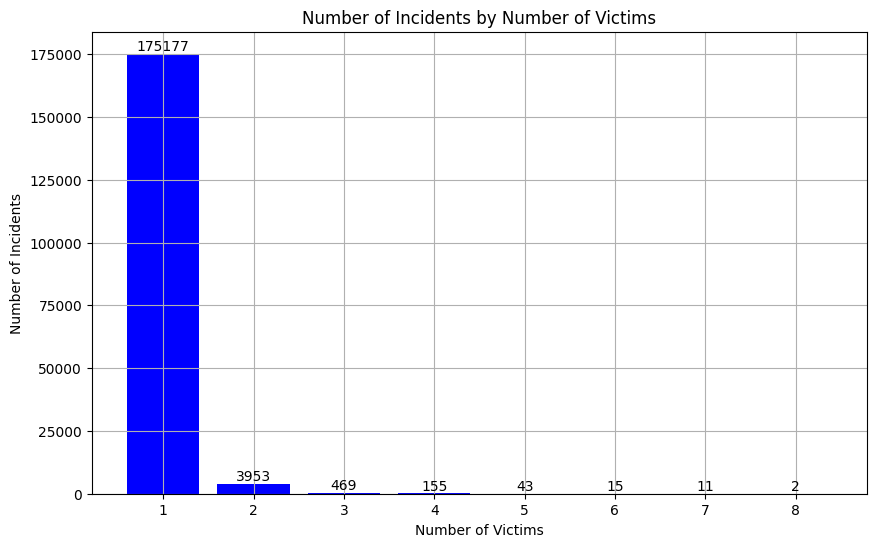

In [61]:
count=0
for i in range(100):
  if df_final.loc[df_final['Victims'].astype(int)>i].count()[0] == 0:
    break
  else:
    count=count+1
print(count)

# Extract the data from the loop
victims = []
incidents = []
for i in range(1,count+1):
  victims.append(i)
  incidents.append(df_final.loc[df_final['Victims'].astype(int) == i].count()[0])

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(victims, incidents, color='blue')

# Add labels and title
plt.xlabel("Number of Victims")
plt.ylabel("Number of Incidents")
plt.title("Number of Incidents by Number of Victims")

# Add grid and show the plot
plt.grid(True)

# Add numbers on top of each bar
for i, v in enumerate(victims):
  plt.text(v, incidents[i], str(incidents[i]), ha='center', va='bottom')

plt.show()

Rape: 1132
Sodomy: 487
Sexual Offence: 43


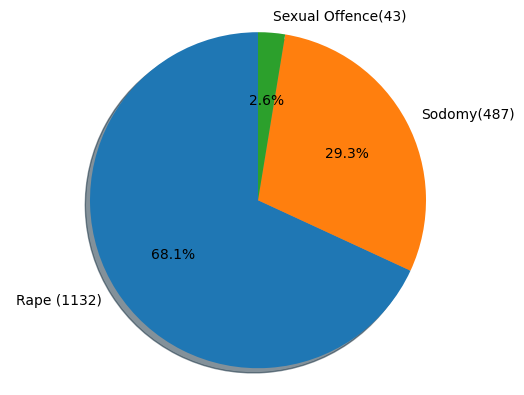

In [72]:
# Initialize variables
r = 0
so = 0
se = 0

# Loop through the 'Crime Detail' column of df_final
for i in df_final['Crime Detail']:
    if 'RAPE' in i:
        r += 1
    elif 'SODOMY' in i:
        so += 1
    elif 'SEX' in i:
        se += 1

# Print the counts
print(f"Rape: {r}")
print(f"Sodomy: {so}")
print(f"Sexual Offence: {se}")

# Create a pie chart
labels = ['Rape ('+str(r)+')', 'Sodomy('+str(so)+')', 'Sexual Offence('+str(se)+')']
sizes = [r, so, se]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart

# Show the pie chart
plt.show()

In [102]:
data = {'Year': list(df_final['Year'].value_counts().index),
        'Count': list(df_final['Year'].value_counts())}
dff = pd.DataFrame(data)
dff.sort_values(by='Year',inplace = True)

x = dff['Year']
y = dff['Count']
plt.figure(figsize=(15,6))
plt.plot(x,y)
plt.xticks(rotation=90)

,Year,Count
8,2016,42
7,2017,129
6,2018,408
2,2019,34409
3,2020,33118
4,2021,31975
1,2022,34923
0,2023,36147
5,2024,8578


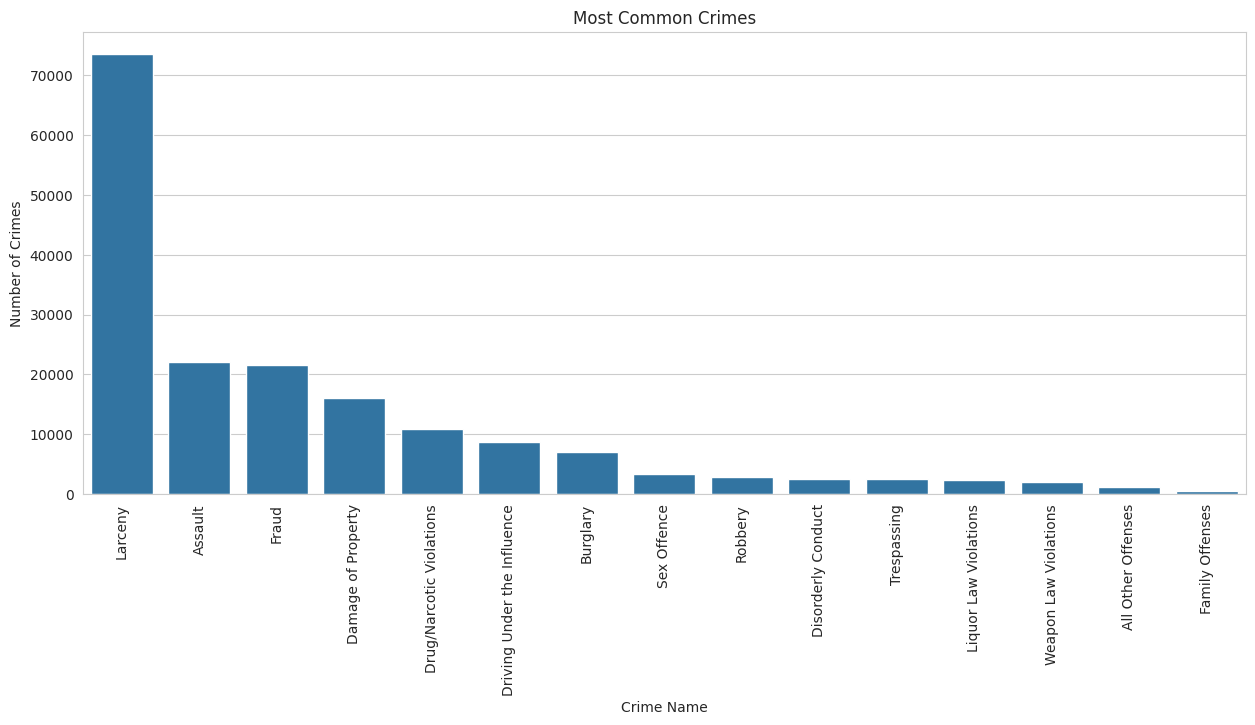

In [77]:
import seaborn as sns

# Set the Seaborn style
sns.set_style("whitegrid")

# Define the data
x = df_final['Crime Name'].value_counts().head(15).index
y = df_final['Crime Name'].value_counts().head(15)

# Create the bar plot
plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y)
plt.xticks(rotation=90)

# Add a title and labels
plt.title("Most Common Crimes")
plt.xlabel("Crime Name")
plt.ylabel("Number of Crimes")

# Show the plot
plt.show()

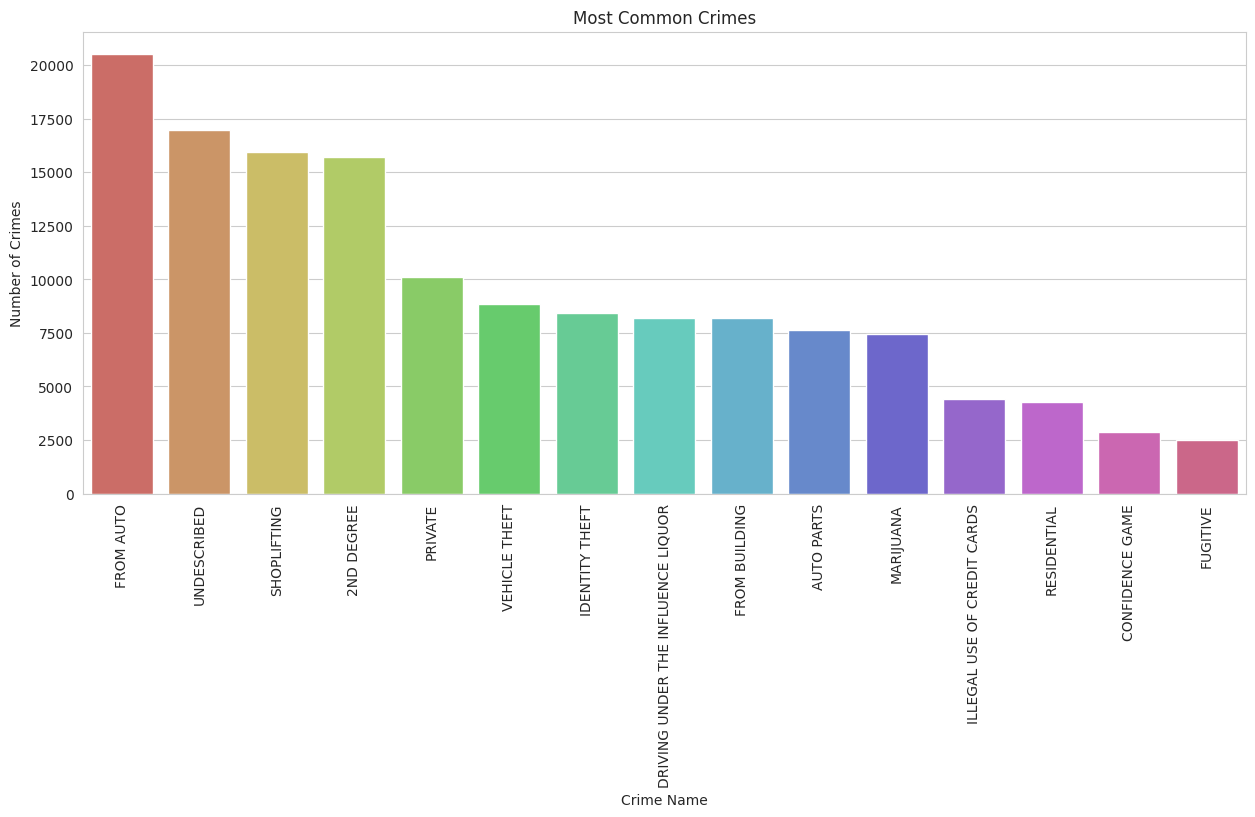

In [83]:
# Set the Seaborn style
sns.set_style("whitegrid")

# Define the data
x = df_final['Crime Detail'].value_counts().head(15).index
y = df_final['Crime Detail'].value_counts().head(15)

# Create the bar plot
plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="hls")
plt.xticks(rotation=90)

# Add a title and labels
plt.title("Most Common Crimes")
plt.xlabel("Crime Name")
plt.ylabel("Number of Crimes")

# Show the plot
plt.show()

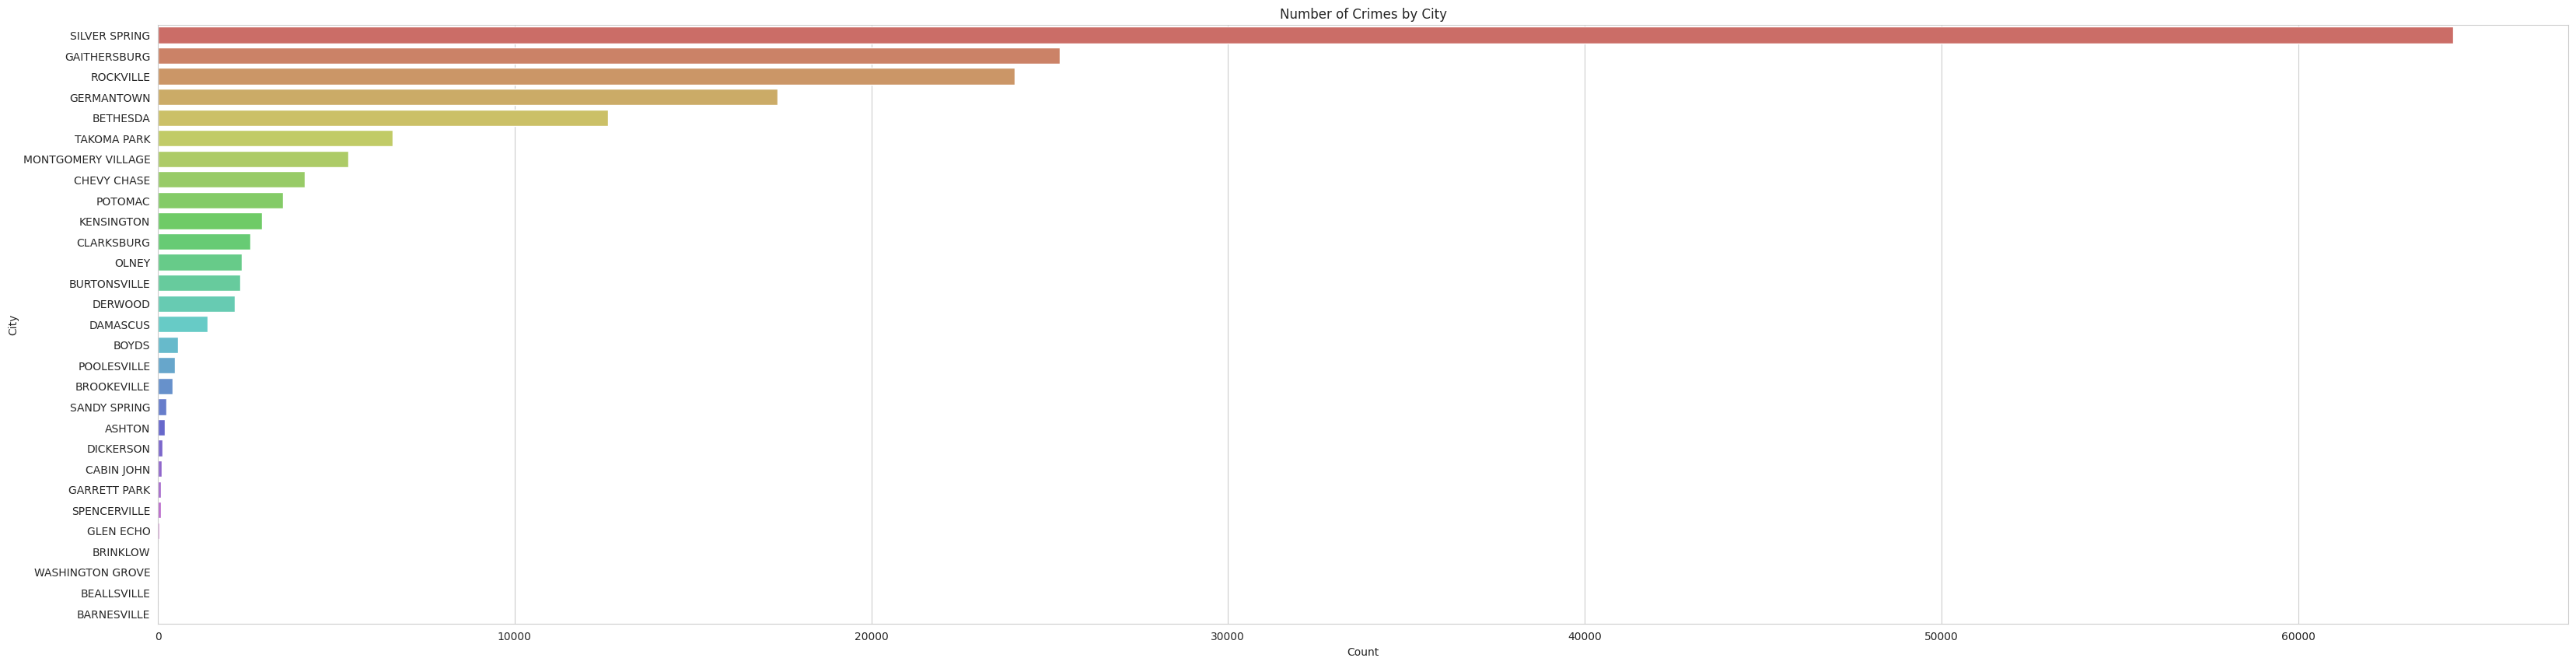

In [89]:
x = df_final['City'].value_counts().index
y = df_final['City'].value_counts()

# Create a DataFrame from the data
dff = pd.DataFrame({
    "City": x,
    "Count": y
})

# Sort the data by count
dff = dff.sort_values(by="Count", ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(40, 10))
sns.barplot(data=dff, x="Count", y="City", palette="hls")

# Add a title and labels
plt.title("Number of Crimes by City")
plt.xlabel("Count")
plt.ylabel("City")

# Show the plot
plt.show()

<BarContainer object of 12 artists>

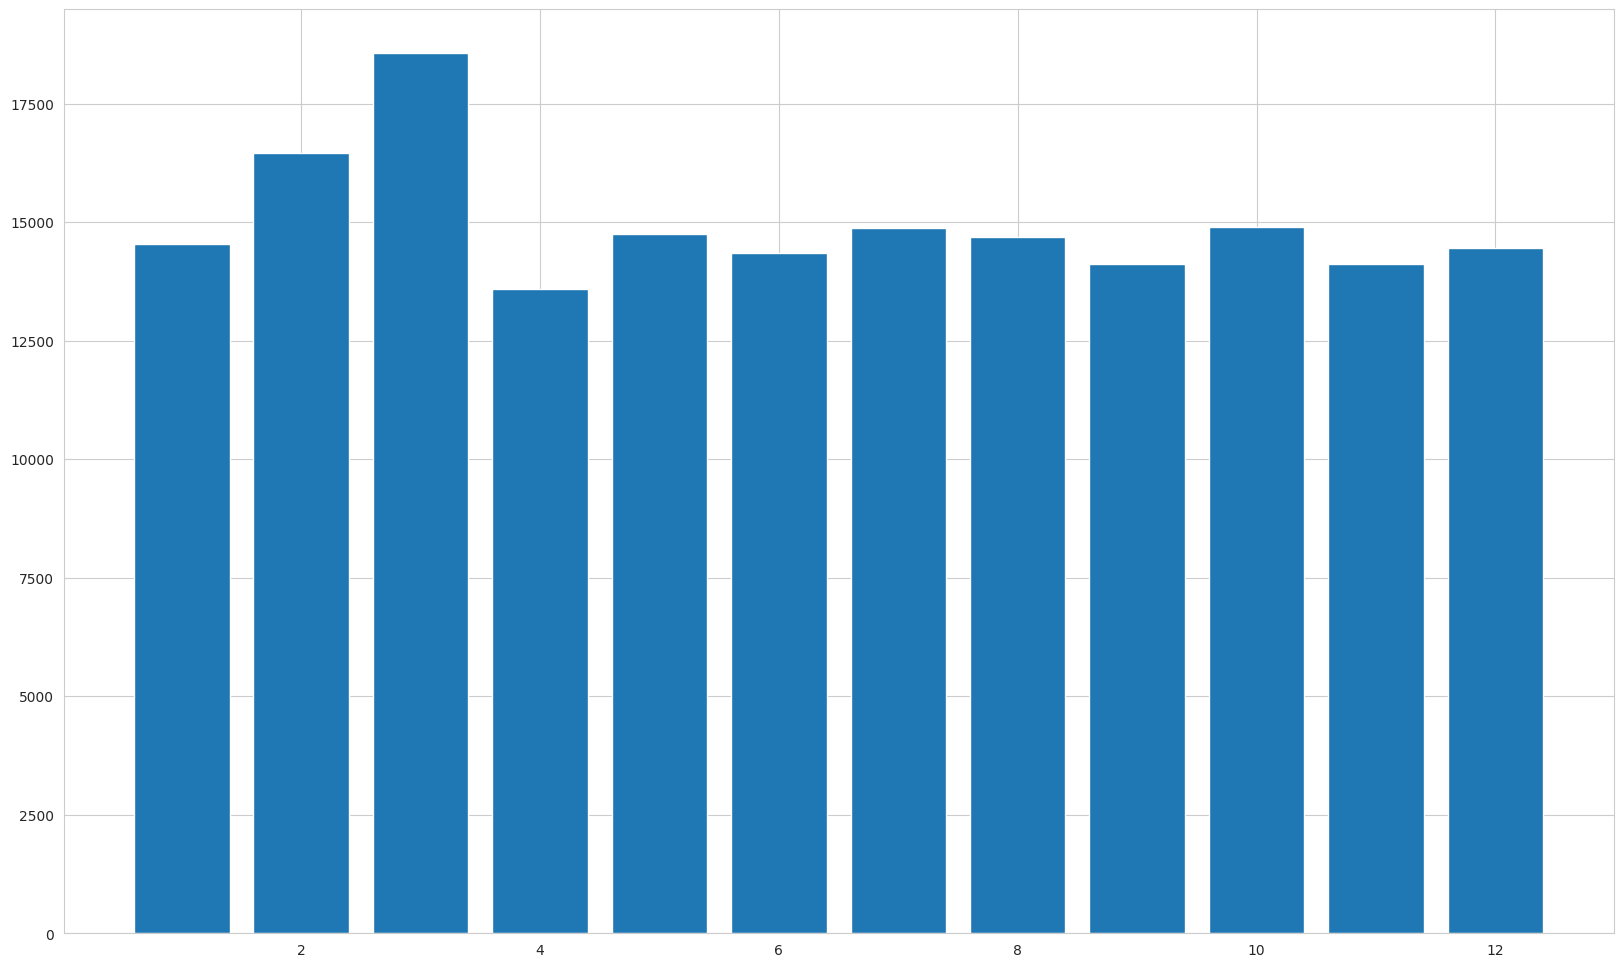

In [101]:
zz = df_final['Month'].value_counts()
data = {'Month': list(df_final['Month'].value_counts().index),
        'Count': list(df_final['Month'].value_counts())}
dff = pd.DataFrame(data)
dff.sort_values(by='Month',inplace = True)
plt.figure(figsize=(20,12))
plt.bar(dff['Month'],dff['Count'])

In [217]:
df_try['Year'].unique()

array([2019, 2020, 2021, 2022, 2023, 2024])

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 [Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10'),
  Text(12.0, 0, '12'),
  Text(14.0, 0, '14')])

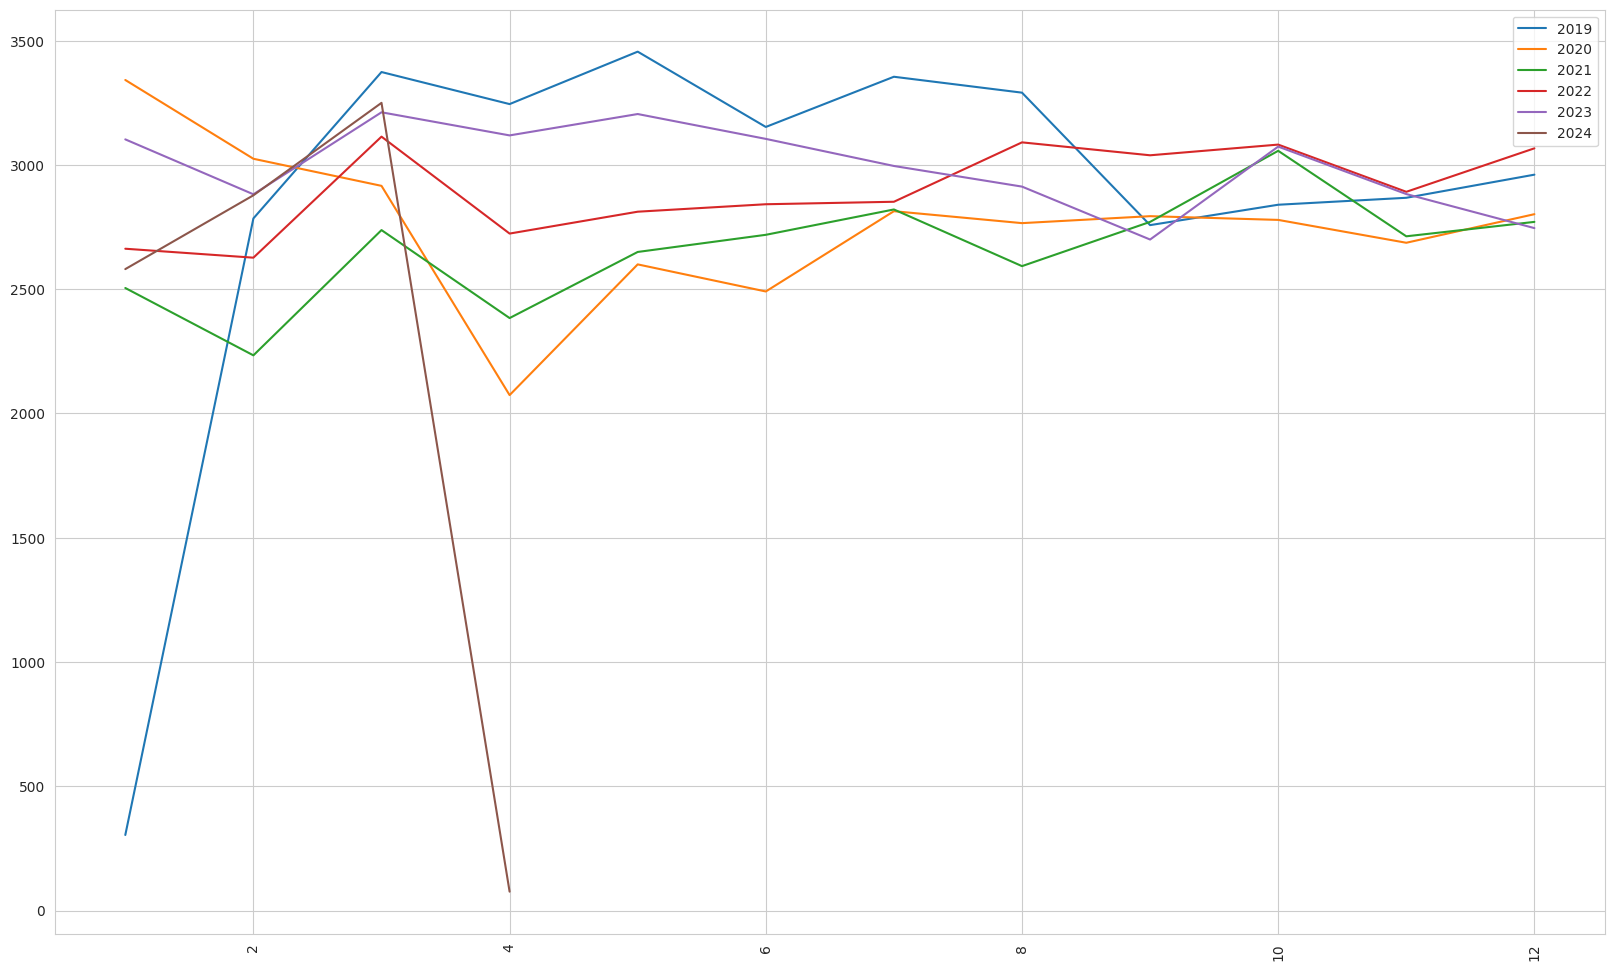

In [218]:
df_try=df_final
df_try.drop(df_try.loc[df_try['Year'] == 2016].index, inplace=True)
df_try.drop(df_try.loc[df_try['Year'] == 2017].index, inplace=True)
df_try.drop(df_try.loc[df_try['Year'] == 2018].index, inplace=True)

y=[]
x=[1,2,3,4,5,6,7,8,9,10,11,12]
for i in df_try['Year'].unique():
  zz = df_try.loc[df_try['Year'] == i]

  data = {'Year': list(zz['Year_Month'].value_counts().index),
        'Count': list(zz['Year_Month'].value_counts())}
  dff = pd.DataFrame(data)
  dff.sort_values(by='Year',inplace = True)

  y.append(dff['Count'])

plt.figure(figsize=(20,12))
plt.plot(x,y[0],label='2019')
plt.plot(x,y[1],label='2020')
plt.plot(x,y[2],label='2021')
plt.plot(x,y[3],label='2022')
plt.plot(x,y[4],label='2023')
plt.plot([1,2,3,4],y[5],label='2024')
plt.legend()
plt.xticks(rotation=90)

Text(220.72222222222223, 0.5, 'Count')

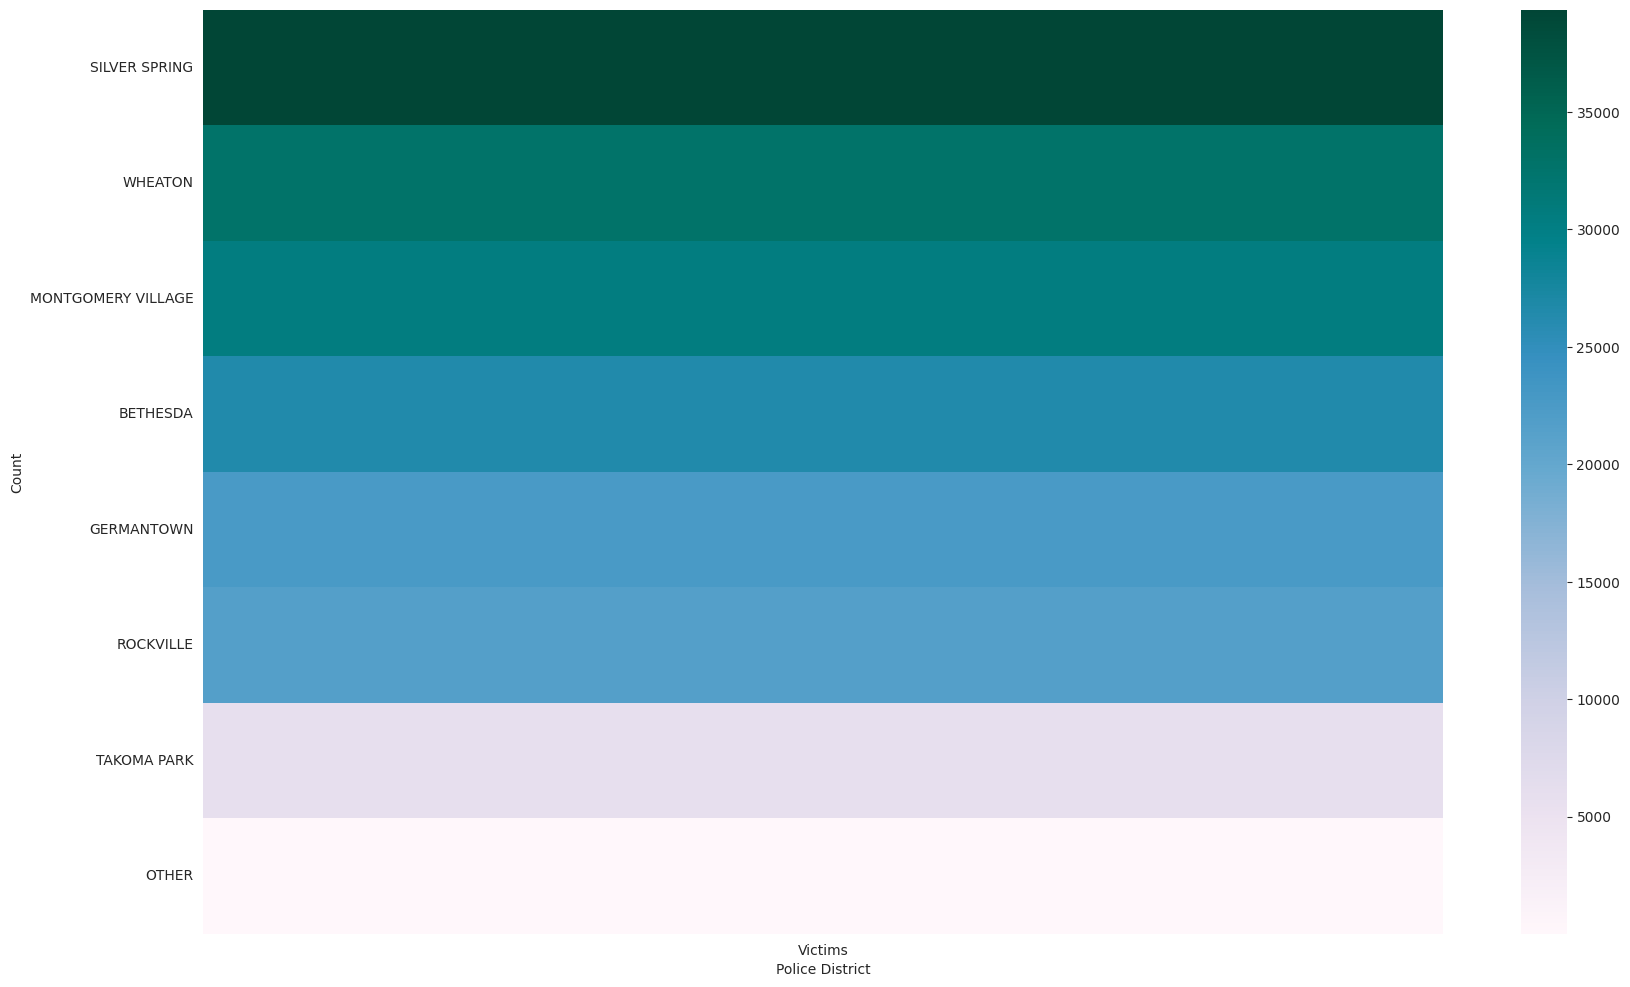

In [108]:

pivot_table = df_final.pivot_table(values='Victims', index='Police District', aggfunc='count').sort_values(by='Victims', ascending=False)

plt.figure(figsize=(20, 12))
sns.heatmap(pivot_table, cmap='PuBuGn')
plt.xlabel("Police District")
plt.ylabel("Count")

# **TEMPORAL ANAYSIS AND PREDICTION**

In [213]:
df_try=df_final
df_try.drop(df_try.loc[df_try['Year'] == 2016].index, inplace=True)
df_try.drop(df_try.loc[df_try['Year'] == 2017].index, inplace=True)
df_try.drop(df_try.loc[df_try['Year'] == 2018].index, inplace=True)

In [121]:
data_ml = {'Date': list(df_try['Date'].value_counts().index),
        'Count': list(df_try['Date'].value_counts())}
df_ml = pd.DataFrame(data_ml)
df_ml.dropna(inplace=True)
df_ml.sort_values(by='Date',inplace = True)
df_ml.reset_index(drop=True,inplace=True)
df_ml = pd.DataFrame(df_ml)


In [122]:
df_ml['Date'] = pd.to_datetime(df_ml['Date'])
df_ml = df_ml.sort_values(by='Date')
df_ml = df_ml.reset_index(drop=True)
df_ml.drop(df_ml.index[-1],inplace=True)
df_ml.set_axis(df_ml['Date'], axis=0, inplace=True)
df_ml.drop(columns=['Date'],inplace=True)

In [123]:
df_ml

,Count
Date,
2019-01-01,57
2019-01-02,4
2019-01-03,7
2019-01-05,2
2019-01-06,6
...,...
2024-03-27,68
2024-03-28,86
2024-03-29,80


In [125]:
df_ml_train=df_ml.iloc[:-15,:]
df_ml_test =df_ml.iloc[-15:-1,:]

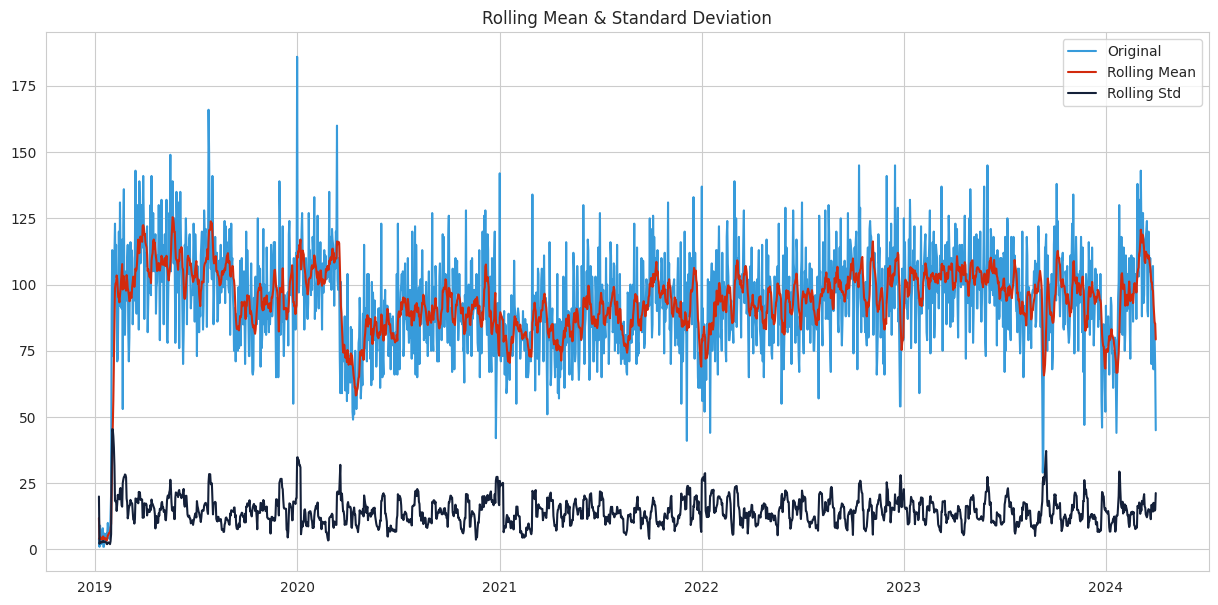

In [126]:
#Determine rolling statistics
df_ml["rolling_avg"] = df_ml["Count"].rolling(window=7).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df_ml["rolling_std"] = df_ml["Count"].rolling(window=7).std()
df_ml.dropna(inplace=True)

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_ml["Count"], color='#379BDB', label='Original')
plt.plot(df_ml["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_ml["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [127]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_ml_train['Count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -8.400513e+00
p-value                        2.237989e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.878000e+03
Critical Value (1%)           -3.433837e+00
Critical Value (5%)           -2.863080e+00
Critical Value (10%)          -2.567590e+00
dtype: float64


In [128]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(list(df_ml_train['Count']),
                        start_p=20,
                        start_q=20,
                        test='adf', # use adftest to find optimal 'd'
                        max_p=35, max_q=35, # maximum p and q
                        m=7, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                        d=None,# let model determine 'd'
                        seasonal=True, # No Seasonality for standard ARIMA
                        trace=False, #logs
                        error_action='warn', #shows errors ('ignore' silences these)
                        suppress_warnings=True,
                        stepwise=True)

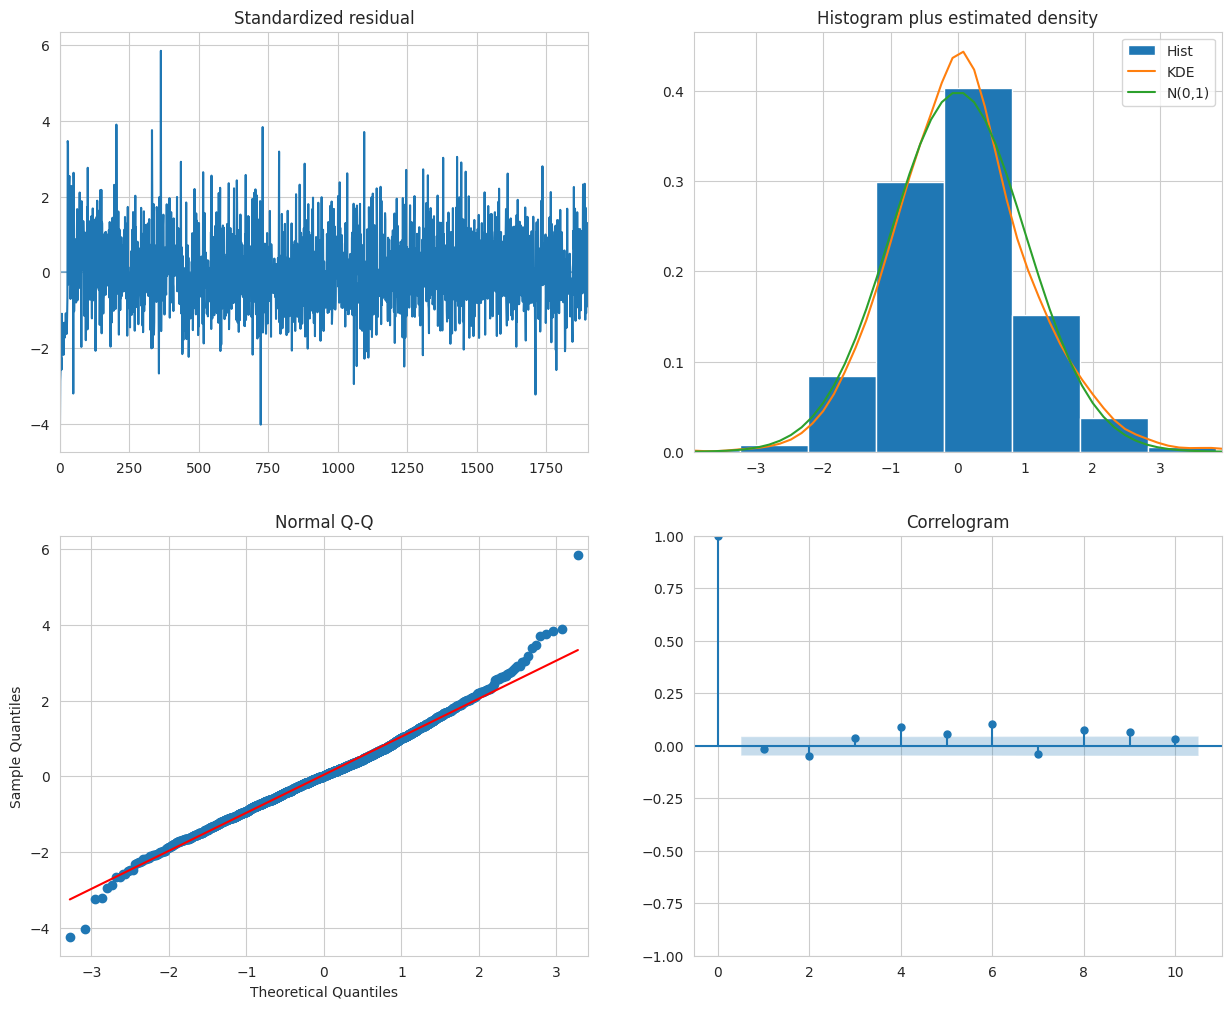

In [129]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

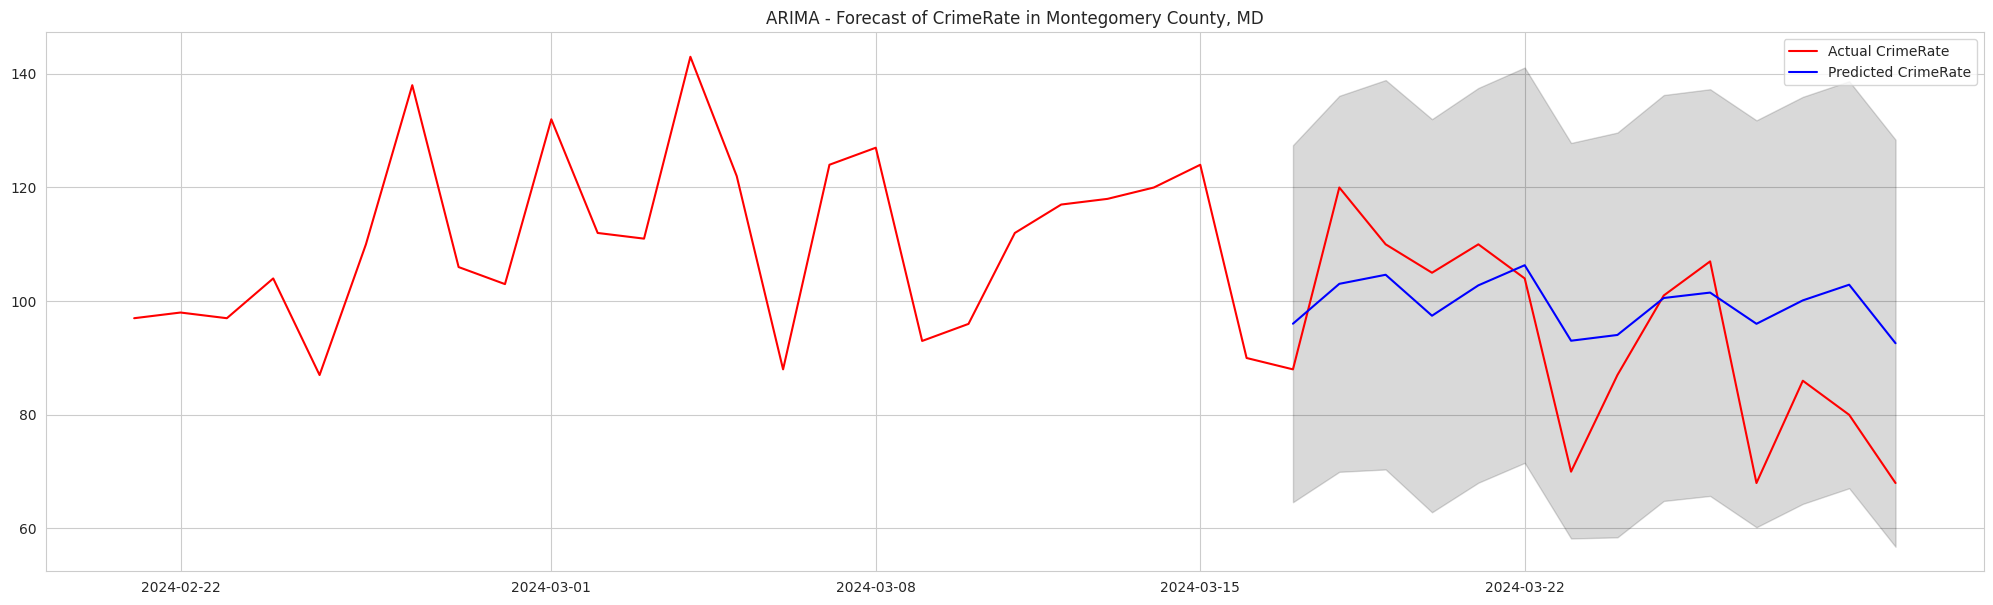

In [130]:
def forecast(ARIMA_model, periods=14):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_ml_train.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)


    # Plot
    plt.figure(figsize=(25,7))
    plt.plot(df_ml.iloc[-40:-1,0], color='red',label='Actual CrimeRate')
    plt.plot(fitted_series, color='blue', label = 'Predicted CrimeRate')
    plt.fill_between(lower_series.index,
                  lower_series,
                  upper_series,
                  color='k', alpha=.15)

    plt.title("ARIMA - Forecast of CrimeRate in Montegomery County, MD")
    plt.legend()
    plt.show()
    return fitted_series


z=forecast(ARIMA_model)

In [131]:
from sklearn.metrics import mean_squared_error, r2_score
print('Mean Squared Error =',mean_squared_error(df_ml.iloc[-15:-1,0],z))
print('Root Mean Square =',r2_score(df_ml.iloc[-15:-1,0],z))

Mean Squared Error = 230.00484172723645
Root Mean Square = 0.17215827496440528


In [132]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
MAPE(df_ml.iloc[-15:-1,0],z)

15.224221583207202

# **GEO-SPACIAL ANALYSIS**

In [203]:
!pip install contextily

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

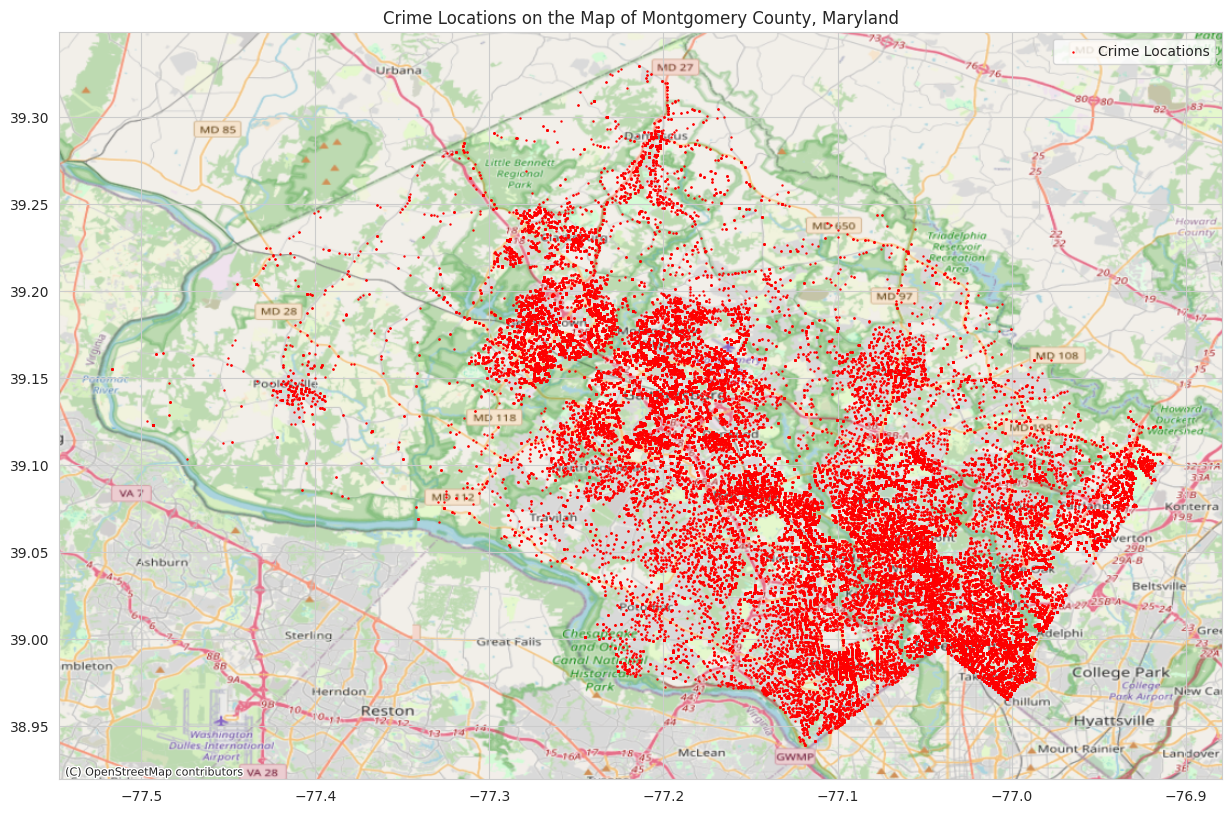

In [219]:
# Prepare your location data
locations = gpd.GeoDataFrame({
    'Latitude': df_final['Latitude'][df_final['Latitude']!=0],
    'Longitude':df_final['Longitude'][df_final['Longitude']!=0],
    'geometry': gpd.points_from_xy(df_final['Longitude'][df_final['Longitude']!=0],df_final['Latitude'][df_final['Latitude']!=0]),
})

# Set the CRS for the locations GeoDataFrame to EPSG:4326
locations.crs = "EPSG:4326"

# Create a simple scatter plot for your locations
fig, ax = plt.subplots(figsize=(15, 15))
locations.plot(ax=ax, markersize=0.5, color='red', label='Crime Locations')

# Fetch and plot the basemap using OpenStreetMap data
ctx.add_basemap(ax, crs=locations.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Crime Locations on the Map of Montgomery County, Maryland')
plt.legend()
plt.show()